<a href="https://colab.research.google.com/github/clairecleverlamb/smart-chatbots/blob/main/systematic_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio

import gradio as gr
from transformers import pipeline

# Initialize the zero-shot classifier (using facebook/bart-large-mnli)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Candidate labels now include an explicit "out_of_scope" option.
CANDIDATE_LABELS = ["greeting", "order_pizza", "menu_question", "out_of_scope"]

# Known pizza types for simple entity extraction simulation.
PIZZA_TYPES = ["pepperoni", "margherita", "vegetarian", "cheese"]

# Confidence threshold for deciding whether a prediction is reliable.
THRESHOLD = 0.7

def conversation_flow(user_input: str, state: dict):

    if state is None:
        state = {"stage": "initial", "order": None}

    text = user_input.strip().lower()

    # Check for immediate goodbye commands.
    if "bye" in text or "goodbye" in text:
        response = "Goodbye! Have a great day. (Resetting conversation.)"
        state = {"stage": "initial", "order": None}
        return response, state

    # Use zero-shot classification to evaluate the input.
    result = classifier(text, CANDIDATE_LABELS)
    top_label = result["labels"][0]
    top_score = result["scores"][0]

    # If confidence is too low or out_of_scope is predicted, return a fallback message.
    if top_score < THRESHOLD or top_label == "out_of_scope":
        response = "I'm not sure I understand. Could you please clarify your request?"
        return response, state

    # Stage: initial
    if state["stage"] == "initial":
        if top_label == "greeting":
            response = "Hello! How can I help you today? You can say something like 'I want to order a pizza.'"
            state["stage"] = "awaiting_intent"
        elif top_label == "order_pizza":
            response = "Great! What type of pizza would you like? (e.g., pepperoni, margherita)"
            state["stage"] = "awaiting_pizza_type"
        elif top_label == "menu_question":
            response = "Our menu includes pepperoni, margherita, vegetarian, and cheese pizzas. Would you like to place an order?"
            state["stage"] = "awaiting_intent"
        else:
            response = "I'm not sure I understand. Could you please clarify your request?"
            state["stage"] = "awaiting_intent"
        return response, state

    # Stage: awaiting_intent
    elif state["stage"] == "awaiting_intent":
        if top_label == "order_pizza":
            response = "Great! What type of pizza would you like? (e.g., pepperoni, margherita, vegetarian)"
            state["stage"] = "awaiting_pizza_type"
        elif top_label == "menu_question":
            response = "Our menu includes pepperoni, margherita, vegetarian, and cheese pizzas. Would you like to place an order?"
        elif top_label == "greeting":
            response = "Hi again! How can I assist you? If you'd like to order a pizza, just let me know."
        else:
            response = "Could you please specify your request? For example, say 'I want to order a pizza.'"
        return response, state

    # Stage: awaiting_pizza_type
    elif state["stage"] == "awaiting_pizza_type":
        found_type = None
        for pizza in PIZZA_TYPES:
            if pizza in text:
                found_type = pizza
                break
        if found_type:
            response = f"Got it! Your order for a {found_type} pizza has been placed. Thank you!"
            state["order"] = found_type
            state["stage"] = "order_confirmed"
        else:
            response = "I didn't catch the pizza type. Could you please specify (e.g., pepperoni, margherita, vegetarian, cheese)?"
        return response, state

    # Stage: order_confirmed
    elif state["stage"] == "order_confirmed":
        response = "Your order is confirmed. If you'd like to order another pizza or have more questions, just let me know!"
        # Reset state for new orders.
        state["stage"] = "awaiting_intent"
        state["order"] = None
        return response, state

    # Fallback: reset conversation.
    else:
        response = "I'm not sure how to proceed. Let's start over. How can I help you today?"
        state = {"stage": "initial", "order": None}
        return response, state

def chat_interface(user_message, history, state):

    if state is None:
        state = {"stage": "initial", "order": None}
    response, state = conversation_flow(user_message, state)
    history = history or []
    history.append((user_message, response))
    return history, state


with gr.Blocks() as demo_chat:
    gr.Markdown("# Pizza Ordering Chatbot")
    gr.Markdown(
        "This chatbot helps you order pizza"

    )
    chatbot = gr.Chatbot()
    state = gr.State({"stage": "initial", "order": None})
    txt = gr.Textbox(show_label=False, placeholder="Type your message here and press Enter")
    txt.submit(chat_interface, inputs=[txt, chatbot, state], outputs=[chatbot, state])


demo_chat.launch()



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
tor

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
<ipython-input-1-296ab15a44b7>:115: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ef81ec297f85333061.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install transformers datasets evaluate

import json
import numpy as np
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
import evaluate


with open("example.json", "r") as f:
    data = json.load(f)

# Extract texts and labels
texts = [item["text"] for item in data]
labels_str = [item["label"] for item in data]

# Create a label mapping (string-to-integer) based on unique labels
unique_labels = sorted(list(set(labels_str)))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

# Convert labels in the dataset to numeric form
numeric_labels = [label2id[label] for label in labels_str]

# Create a Hugging Face Dataset
dataset_dict = {"text": texts, "label": numeric_labels}
dataset = Dataset.from_dict(dataset_dict)

# Split into train (80%) and test (20%) sets
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]


model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=64)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Format datasets to return PyTorch tensors
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


num_labels = len(unique_labels)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


model.config.label2id = label2id
model.config.id2label = id2label

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1,
    seed=42,
    metric_for_best_model="accuracy"
)

# Define the evaluation metric: accuracy
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": acc}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()

eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


save_directory = "./pizza_model"
trainer.save_model(save_directory)
print(f"Model saved to {save_directory}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


<ipython-input-4-2a63fb3e1677>:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bho-ciao17 (bho-ciao17-trd-studios) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.315451,0.416667
2,1.336300,1.246445,0.833333
3,1.336300,1.220242,0.833333


Evaluation Results: {'eval_loss': 1.2464450597763062, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 1.2493, 'eval_samples_per_second': 9.605, 'eval_steps_per_second': 1.601, 'epoch': 3.0}
Model saved to ./pizza_model


Overall Accuracy: 83.33%

Classification Report:
               precision    recall  f1-score   support

      goodbye       1.00      1.00      1.00         3
     greeting       1.00      1.00      1.00         3
menu_question       0.50      1.00      0.67         2
  order_pizza       1.00      0.50      0.67         4

     accuracy                           0.83        12
    macro avg       0.88      0.88      0.83        12
 weighted avg       0.92      0.83      0.83        12



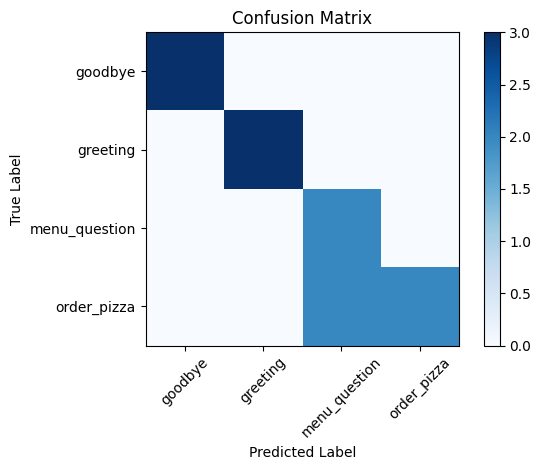


Misclassified Examples (up to 10 shown):
Text: Can I get a large pepperoni pizza please?
True Label: order_pizza, Predicted: menu_question

Text: Can I have a large pepperoni pizza please?
True Label: order_pizza, Predicted: menu_question



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
    output_all_columns=True
)
test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
    output_all_columns=True
)


predictions_output = trainer.predict(test_dataset)
preds = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

# Calculate overall accuracy
accuracy = np.mean(preds == true_labels)
print(f"Overall Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
target_names = [id2label[i] for i in range(num_labels)]
print(classification_report(true_labels, preds, target_names=target_names))


cm = confusion_matrix(true_labels, preds)

plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_labels)
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


misclassified = []
for i, (pred, true) in enumerate(zip(preds, true_labels)):
    if pred != true:

        text_str = test_dataset[i]["text"]
        misclassified.append((text_str, id2label[true], id2label[pred]))

print("\nMisclassified Examples (up to 10 shown):")
for text, true_label, pred_label in misclassified[:10]:
    print(f"Text: {text}\nTrue Label: {true_label}, Predicted: {pred_label}\n")


In [ ]:
import random


SYNONYMS_DICT = {
    "order": ["place", "get", "request"],
    "pizza": ["pie", "slice", "dish"],
    "i want": ["i'd like", "i wish to", "i'd prefer"],
    "hello": ["hi", "hey", "greetings"]
}

def simple_synonym_augment(sentence: str, probability: float = 0.3) -> str:

    words = sentence.split()
    new_words = []
    for word in words:
        # Remove punctuation for matching (simple approach)
        key = word.lower().strip(",.!?")
        if key in SYNONYMS_DICT and random.random() < probability:
            synonym = random.choice(SYNONYMS_DICT[key])
            # Preserve capitalization if the original word was capitalized.
            if word[0].isupper():
                synonym = synonym.capitalize()
            new_words.append(synonym)
        else:
            new_words.append(word)
    return " ".join(new_words)

# Example usage on a few sample sentences:
sample_sentences = [
    "I want to order a pepperoni pizza.",
    "Hello, I'd like a pizza.",
    "Can I order a pizza?"
]
print("---- Data Augmentation Demo ----")
for s in sample_sentences:
    augmented = simple_synonym_augment(s)
    print(f"Original: {s}")
    print(f"Augmented: {augmented}\n")



---- Data Augmentation Demo ----
Original: I want to order a pepperoni pizza.
Augmented: I want to place a pepperoni pizza.

Original: Hello, I'd like a pizza.
Augmented: Hey I'd like a pizza.

Original: Can I order a pizza?
Augmented: Can I get a slice

